In [1]:
# Import packages
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose 
import seaborn as sns

In [2]:
df = pd.read_csv("Yearly_revenue.csv")
df.head()

,Yearly_revenue
0,3307
1,3556
2,3601
3,3721
4,4036


In [3]:
start_year = 1955
df['Year'] = range(start_year, start_year + len(df))
df.head()

,Yearly_revenue,Year
0,3307,1955
1,3556,1956
2,3601,1957
3,3721,1958
4,4036,1959


In [4]:
df.shape

(43, 2)

In [5]:
# Convert column year in datetime format
df['Year'] = pd.to_datetime([f'{year}-01-01' for year in df['Year']])
df = df.set_index('Year')

In [6]:
df.head()

,Yearly_revenue
Year,
1955-01-01,3307
1956-01-01,3556
1957-01-01,3601
1958-01-01,3721
1959-01-01,4036


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'Yearly_revenue')

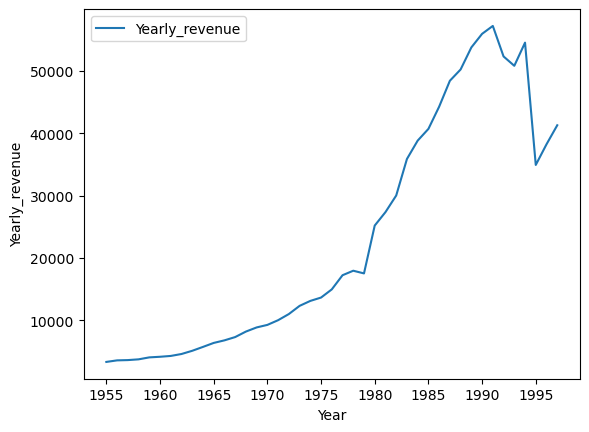

In [7]:
sns.lineplot(df)
plt.ylabel("Yearly_revenue")

In [8]:
# we can see that only trend is present in the data. Seasonality is not present. Hence we need not decompose the data.
#If Your Data Represents Sub-Year Frequencies:

#Monthly Data: Set period=12 (12 months per year).
#Quarterly Data: Set period=4 (4 quarters per year).

In [9]:
import pymannkendall as mk

# Perform Mann-Kendall test
# H0: There is no monotonic trend in the series

mk.original_test(df[['Yearly_revenue']])

Mann_Kendall_Test(trend='increasing', h=True, p=0.0, z=8.56071397786077, Tau=0.9069767441860465, s=819.0, var_s=9130.333333333334, slope=1225.8695652173913, intercept=-10793.260869565216)

In [10]:
#pvalue <0.5 => reject Ho. There is a trend present

In [11]:
train_df=df[:int(df.shape[0]*0.7)]
test_df=df[int(df.shape[0]*0.7):]

In [12]:
test_df.shape

(13, 1)

In [13]:
#DOUBLE EXPONENTIAL MODEL
from statsmodels.tsa.api import Holt

model_double = Holt(train_df)
model_double_fit = model_double.fit()

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


In [14]:
model_double_fit.params

{'smoothing_level': 0.5942857142857142,
 'smoothing_trend': 0.5942857142857142,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 3307.0,
 'initial_trend': 249.0,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [15]:
test_predictions = model_double_fit.forecast(len(test_df)).rename('Holts Test Forecast')

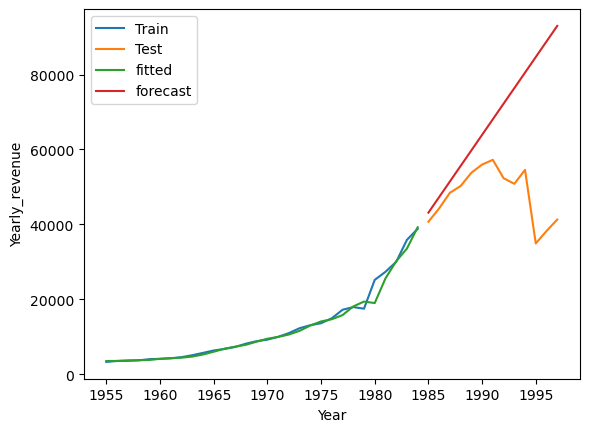

In [16]:
plt.plot(train_df['Yearly_revenue'],label='Train')
plt.plot(test_df['Yearly_revenue'], label = 'Test')
plt.plot(model_double_fit.fittedvalues , label='fitted')
plt.plot(test_predictions , label ='forecast')
plt.xlabel('Year')
plt.ylabel('Yearly_revenue')
plt.legend()
plt.show()

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
mape_test = mean_absolute_percentage_error(test_df['Yearly_revenue'],test_predictions)
print('MAPE for Test Data:', mape_test)

MAPE for Test Data: 0.46881146615572106


In [18]:
#ADF TEST
#Null Hypothesis (HO): Series is non-stationary, or series has a unit root.
#Alternate Hypothesis(HA): Series is stationary, or series has no unit root.
#p-value < 0.05 – Reject Null Hypothesis(HO)

In [19]:
from statsmodels.tsa.stattools import adfuller
print("Results of Dickey-Fuller Test:")
dftest = adfuller(df['Yearly_revenue'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                 -1.218203
p-value                         0.665717
#Lags Used                      6.000000
Number of Observations Used    36.000000
Critical Value (1%)            -3.626652
Critical Value (5%)            -2.945951
Critical Value (10%)           -2.611671
dtype: float64


In [20]:
#Here the condition is not satisfied so we fail to reject the null hypothesis i.e Series is NOT stationary

In [21]:
#KPSS TEST
#Null Hypothesis (HO): Series is trend stationary or series has no unit root.
#Alternate Hypothesis(HA): Series is non-stationary, or series has a unit root.
#p-value < 0.05 –  Reject Null Hypothesis(HO)

In [22]:
from statsmodels.tsa.stattools import kpss
kp = kpss(df['Yearly_revenue'])
p = kp[1]

print("p-value for KPSS test (untransformed) = ", p)


p-value for KPSS test (untransformed) =  0.01


C:\Users\Tanvi.Koyande\AppData\Local\Temp\ipykernel_8260\1758192262.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kp = kpss(df['Yearly_revenue'])


In [23]:
#Here p-value is less than 0.05 so reject Null Hypothesis i.e data is NOT trend stationary

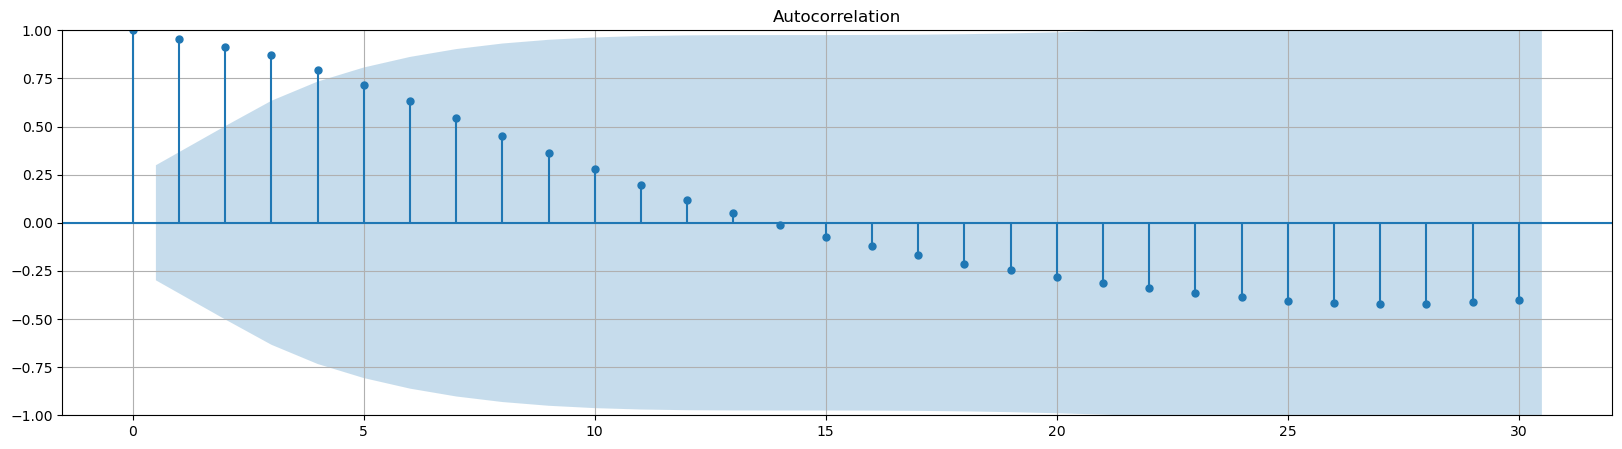

In [24]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(20, 5))
plt.grid()
plot_acf(df['Yearly_revenue'] , ax=plt.gca(), lags =30 )
plt.show()

In [25]:
#The slow decay in the autocorrelation function is a strong indication that your time series data exhibits a trend or is non-stationary.

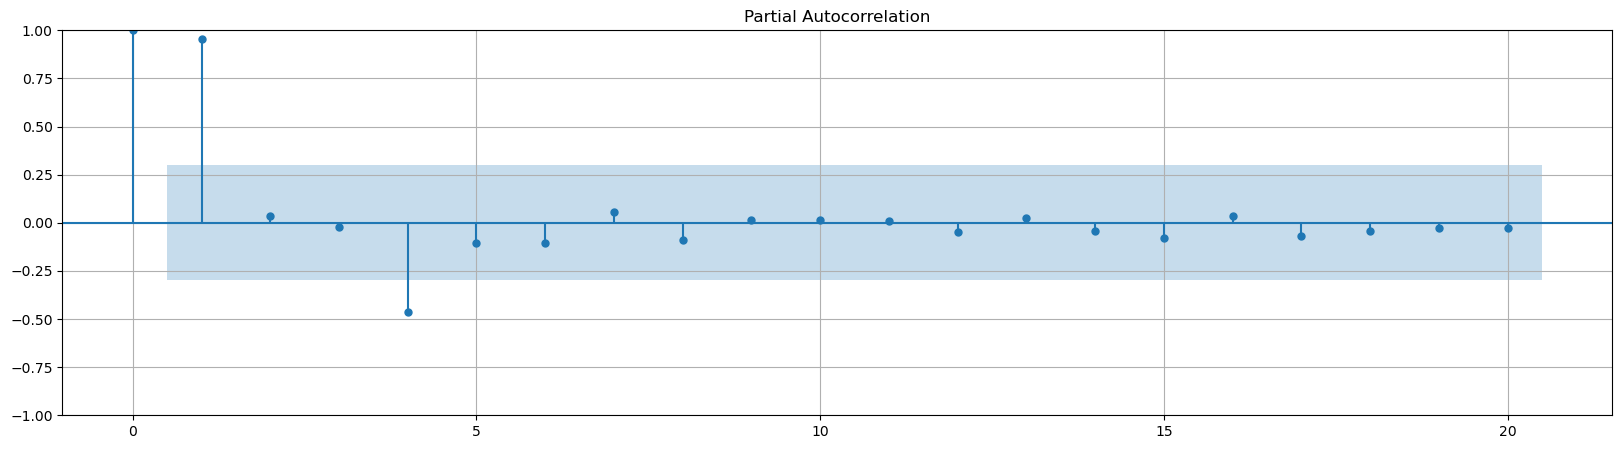

In [26]:
plt.figure(figsize=(20, 5))
plt.grid()
plot_pacf(df['Yearly_revenue'], ax=plt.gca(), lags = 20)
plt.show()

In [27]:
#Combined with your previous ACF plot (which showed a slow decay), the time series appears non-stationary. 
#The strong correlation at lag 1 in both ACF and PACF often signals the presence of a trend in the data

In [28]:
#So to make the data trend stationary we do differencing

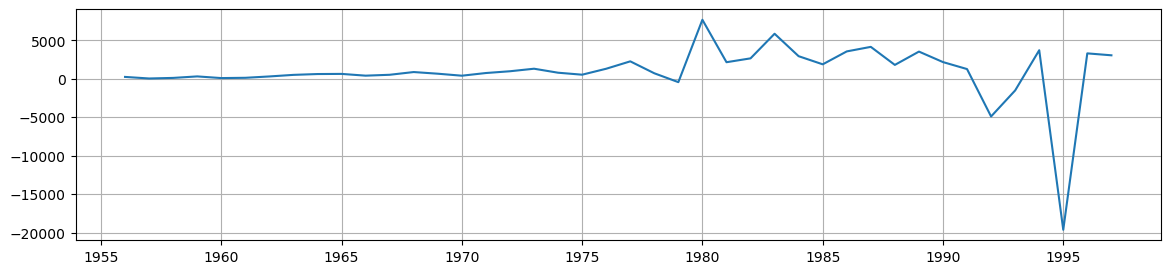

In [29]:
#FIRST ORDER NON-SEASONAL DIFFERENCING
diff = df['Yearly_revenue'].diff().dropna()     # TRYING TO MAKE DATA TREND STATIONARY
plt.figure(figsize=(14, 3))
plt.grid()
plt.plot(diff)
plt.show()

In [30]:
#ADF of first order non seasonal differencing
#Null Hypothesis (HO): Series is non-stationary, or series has a unit root.
#Alternate Hypothesis(HA): Series is stationary, or series has no unit root.
#p-value < 0.05 – Reject Null Hypothesis(HO)

print("Results of Dickey-Fuller Test:")
dftest = adfuller(diff)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                 -2.088805
p-value                         0.249040
#Lags Used                      5.000000
Number of Observations Used    36.000000
Critical Value (1%)            -3.626652
Critical Value (5%)            -2.945951
Critical Value (10%)           -2.611671
dtype: float64


In [31]:
#KPSS TEST of first order non seasonal differencing
#Null Hypothesis (HO): Series is trend stationary or series has no unit root.
#Alternate Hypothesis(HA): Series is non-stationary, or series has a unit root.
#p-value < 0.05 –  Reject Null Hypothesis(HO)
from statsmodels.tsa.stattools import kpss
kp = kpss(diff)
p = kp[1]

print("p-value for KPSS test (untransformed) = ", p)

p-value for KPSS test (untransformed) =  0.1


C:\Users\Tanvi.Koyande\AppData\Local\Temp\ipykernel_8260\3521196611.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kp = kpss(diff)


In [32]:
#ADF is accepted and kpss is accepted 
#series is not stationary 

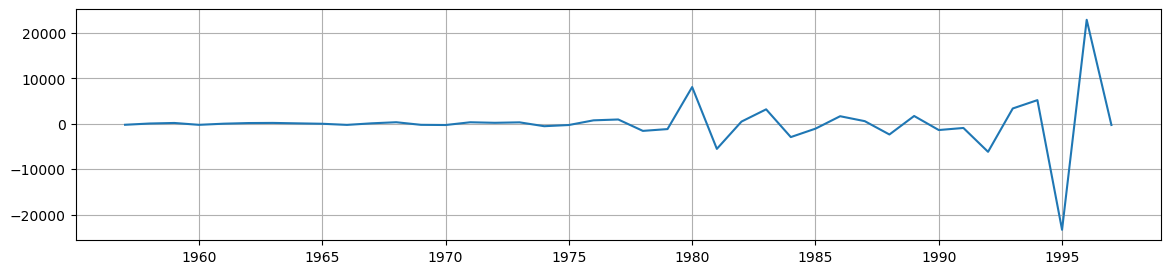

In [33]:
#SECOND ORDER NON-SEASONAL DIFFERENCING
diff2 = df['Yearly_revenue'].diff().diff().dropna()     # TRYING TO MAKE DATA TREND STATIONARY
plt.figure(figsize=(14, 3))
plt.grid()
plt.plot(diff2)
plt.show()

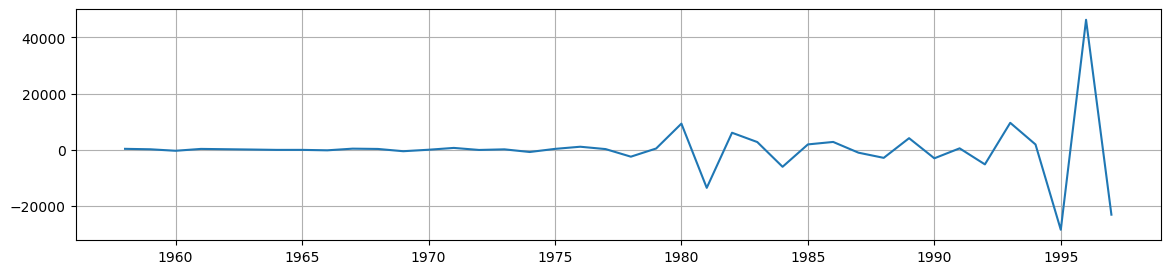

In [34]:
#THIRD ORDER NON-SEASONAL DIFFERENCING
diff3 = df['Yearly_revenue'].diff().diff().diff().dropna()     # TRYING TO MAKE DATA TREND STATIONARY
plt.figure(figsize=(14, 3))
plt.grid()
plt.plot(diff3)
plt.show()

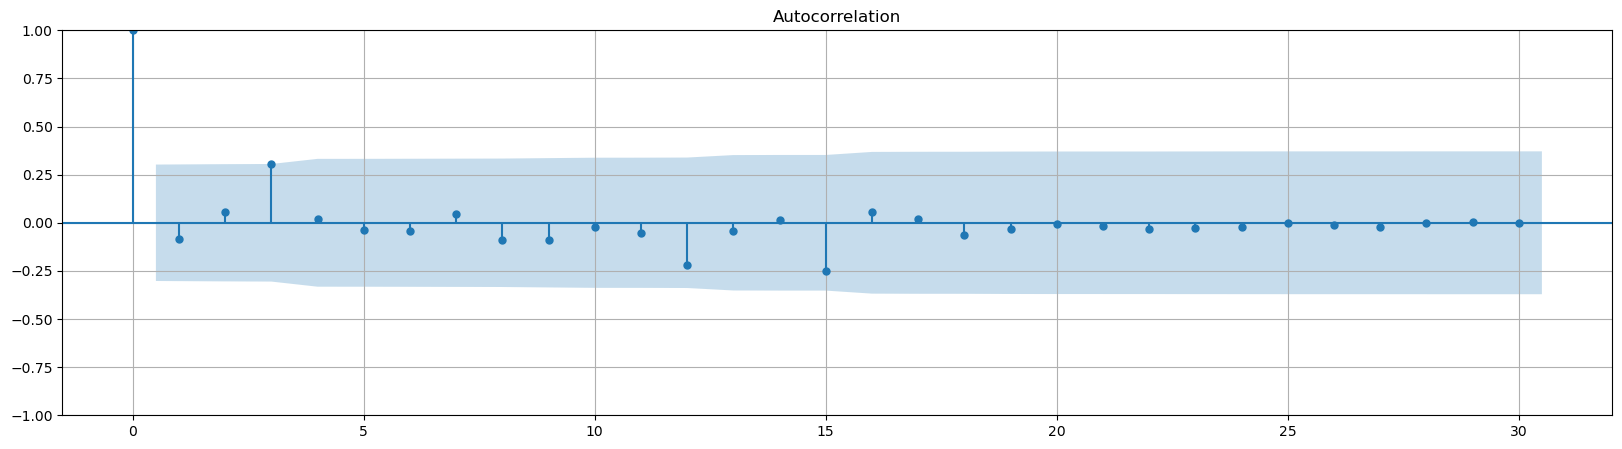

In [35]:
#acf OF FIRST ORDER NON-SEASONAL DIFFERENCING
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(20, 5))
plt.grid()
plot_acf(diff , ax=plt.gca(), lags =30 )
plt.show()

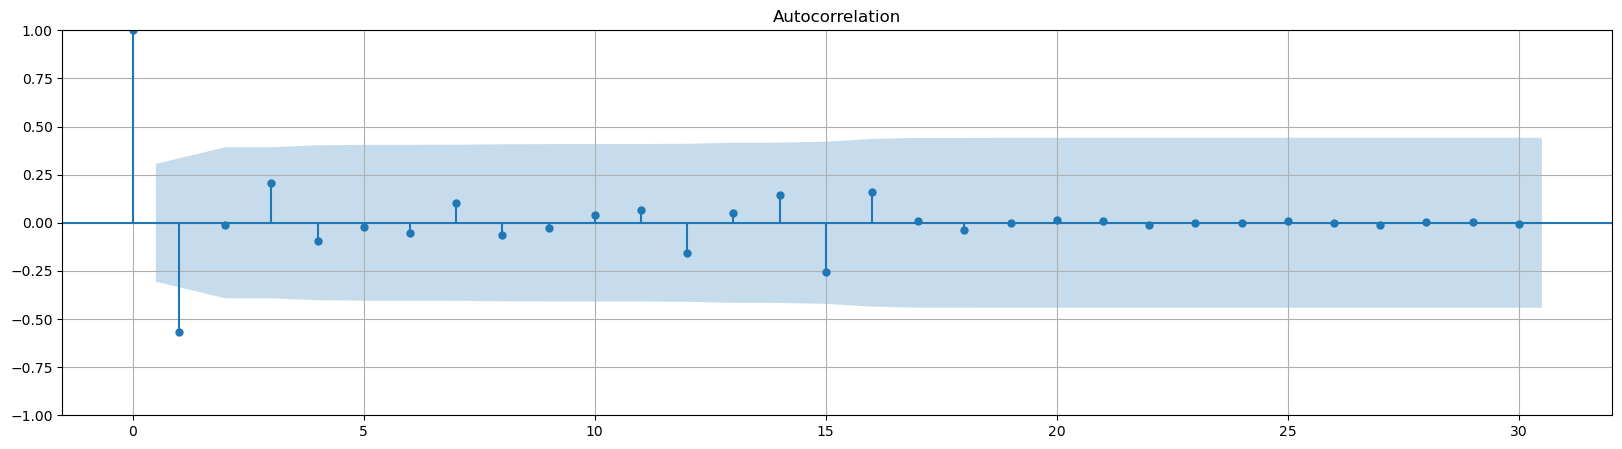

In [36]:
#acf OF #SECOND ORDER NON-SEASONAL DIFFERENCING
plt.figure(figsize=(20, 5))
plt.grid()
plot_acf(diff2 , ax=plt.gca(), lags =30 )
plt.show()

In [37]:
#ADF of second order non seasonal differencing
#Null Hypothesis (HO): Series is non-stationary, or series has a unit root.
#Alternate Hypothesis(HA): Series is stationary, or series has no unit root.
#p-value < 0.05 – Reject Null Hypothesis(HO)

print("Results of Dickey-Fuller Test:")
dftest = adfuller(diff2)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                 -1.081389
p-value                         0.722436
#Lags Used                      4.000000
Number of Observations Used    36.000000
Critical Value (1%)            -3.626652
Critical Value (5%)            -2.945951
Critical Value (10%)           -2.611671
dtype: float64


In [38]:
#KPSS TEST of second order non seasonal differencing
#Null Hypothesis (HO): Series is trend stationary or series has no unit root.
#Alternate Hypothesis(HA): Series is non-stationary, or series has a unit root.
#p-value < 0.05 –  Reject Null Hypothesis(HO)
from statsmodels.tsa.stattools import kpss
kp = kpss(diff2)
p = kp[1]

print("p-value for KPSS test (untransformed) = ", p)

p-value for KPSS test (untransformed) =  0.1


C:\Users\Tanvi.Koyande\AppData\Local\Temp\ipykernel_8260\839855747.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kp = kpss(diff2)


In [39]:
#ADF is accepted and kpss is accepted 
#series is not stationary 

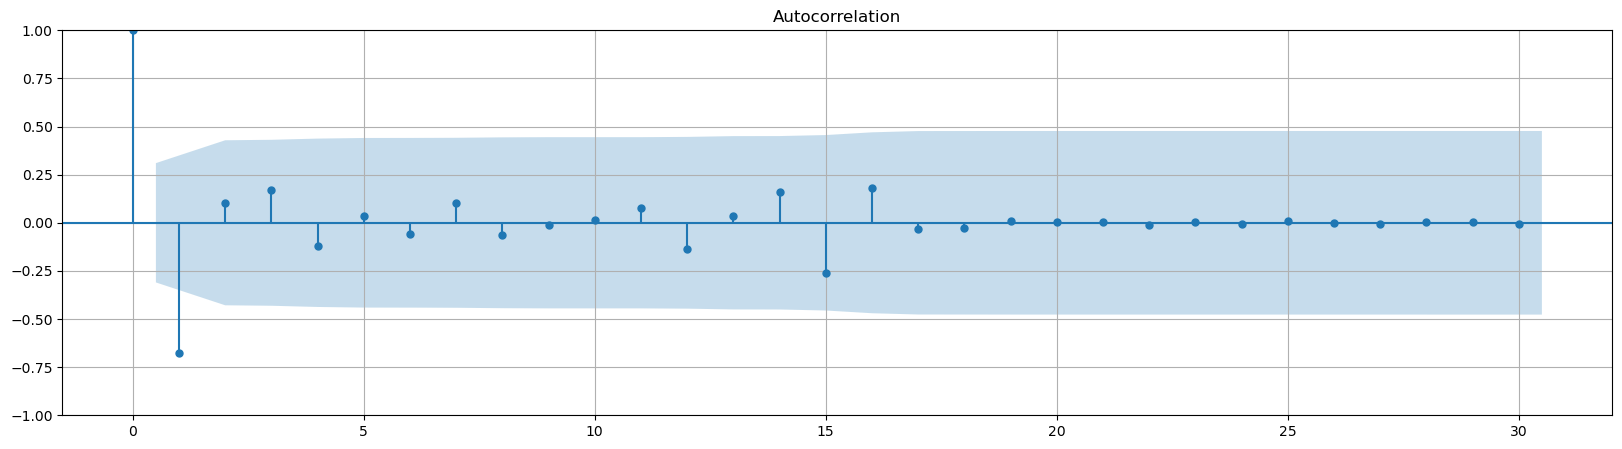

In [40]:
#acf of #THIRD ORDER NON SEASONAL DIFFERENCING
plt.figure(figsize=(20, 5))
plt.grid()
plot_acf(diff3 , ax=plt.gca(), lags =30 )
plt.show()

In [41]:
#ADF of third order non seasonal differencing
#Null Hypothesis (HO): Series is non-stationary, or series has a unit root.
#Alternate Hypothesis(HA): Series is stationary, or series has no unit root.
#p-value < 0.05 – Reject Null Hypothesis(HO)

print("Results of Dickey-Fuller Test:")
dftest = adfuller(diff3)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -9.393147e+00
p-value                        6.479570e-16
#Lags Used                     3.000000e+00
Number of Observations Used    3.600000e+01
Critical Value (1%)           -3.626652e+00
Critical Value (5%)           -2.945951e+00
Critical Value (10%)          -2.611671e+00
dtype: float64


In [42]:
#KPSS TEST of third order non seasonal differencing
#Null Hypothesis (HO): Series is trend stationary or series has no unit root.
#Alternate Hypothesis(HA): Series is non-stationary, or series has a unit root.
#p-value < 0.05 –  Reject Null Hypothesis(HO)
from statsmodels.tsa.stattools import kpss
kp = kpss(diff3)
p = kp[1]

print("p-value for KPSS test (untransformed) = ", p)

p-value for KPSS test (untransformed) =  0.1


C:\Users\Tanvi.Koyande\AppData\Local\Temp\ipykernel_8260\1435152522.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kp = kpss(diff3)


In [43]:
#ADF is rejected and kpss is accepted 
#series is stationary AND the graph of acf is proper

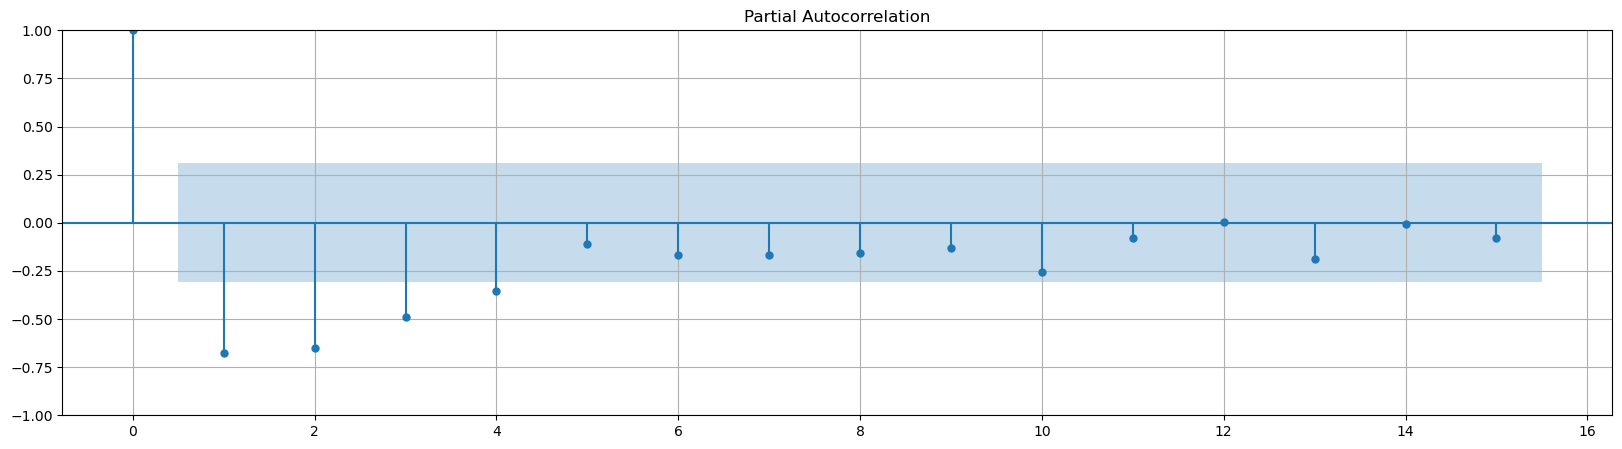

In [47]:
#pacf of #THIRD ORDER NON SEASONAL DIFFERENCING
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(20, 5))
plt.grid()
plot_pacf(diff3 , ax=plt.gca(), lags =15 )
plt.show()

In [ ]:
#INTERPRETATION ON ACF AND PACF
#p (AR order): From the PACF plot, start with 1 since the first lag is significant, and subsequent lags quickly drop off.
#d (Differencing): used third-order differencing to make the series stationary 𝑑=3
#q (MA order): From the ACF plot, start with 1 since there is a single significant spike at lag 1.

In [48]:
from pmdarima.arima import auto_arima
model_auto_arima = auto_arima(df['Yearly_revenue'], seasonal=False, trace = True , m=1)
model_auto_arima_fit = model_auto_arima.fit(df['Yearly_revenue'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=814.859, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=816.564, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=816.822, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=815.224, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=818.603, Time=0.16 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.331 seconds


In [50]:
import statsmodels.api as sm
model_2 = sm.tsa.statespace.SARIMAX(train_df['Yearly_revenue'], order=(0,1,0), seasonal_order = (0,0,0,0))
model_2_fit = model_2.fit()

print(model_2_fit.summary())

                               SARIMAX Results                                
Dep. Variable:         Yearly_revenue   No. Observations:                   30
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -263.093
Date:                Thu, 23 Jan 2025   AIC                            528.186
Time:                        11:40:33   BIC                            529.554
Sample:                    01-01-1955   HQIC                           528.615
                         - 01-01-1984                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.436e+06   6.02e+05      7.368      0.000    3.26e+06    5.62e+06
Ljung-Box (L1) (Q):                   2.23   Jarque-Bera (JB):                71.91
Prob(Q):                              0.14   Pr

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


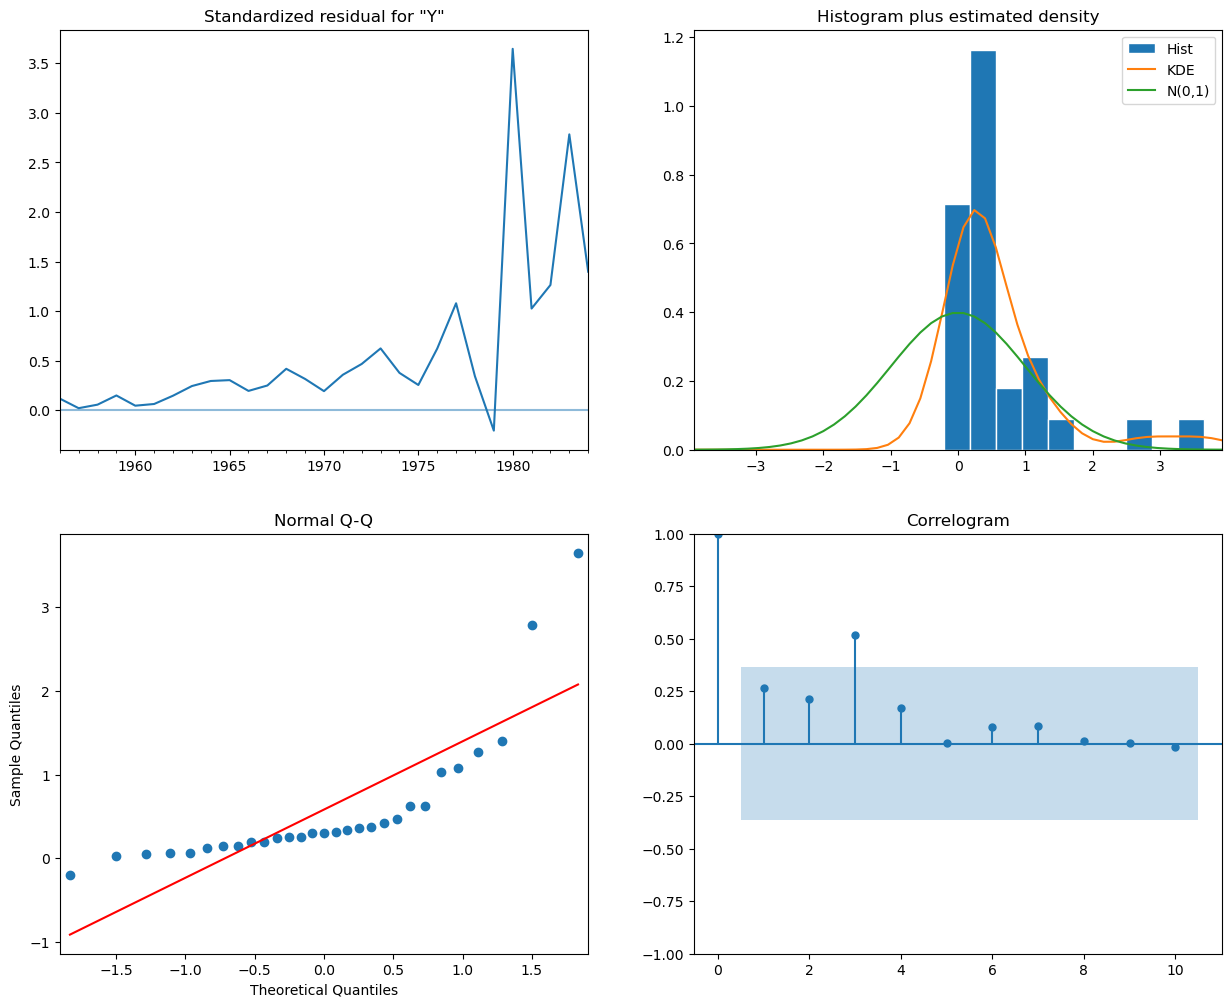

In [51]:
model_2_fit.plot_diagnostics(figsize=(15,12))
plt.show()

In [53]:
test_predictions2 = model_2_fit.forecast(len(test_df))
forecast_further2 = model_2_fit.forecast(len(test_df['Yearly_revenue'])+90)
forecast_further2 = forecast_further2[test_df.index.max():]
forecast_further2

1997-01-01    38828.0
1998-01-01    38828.0
1999-01-01    38828.0
2000-01-01    38828.0
2001-01-01    38828.0
               ...   
2083-01-01    38828.0
2084-01-01    38828.0
2085-01-01    38828.0
2086-01-01    38828.0
2087-01-01    38828.0
Freq: AS-JAN, Name: predicted_mean, Length: 91, dtype: float64

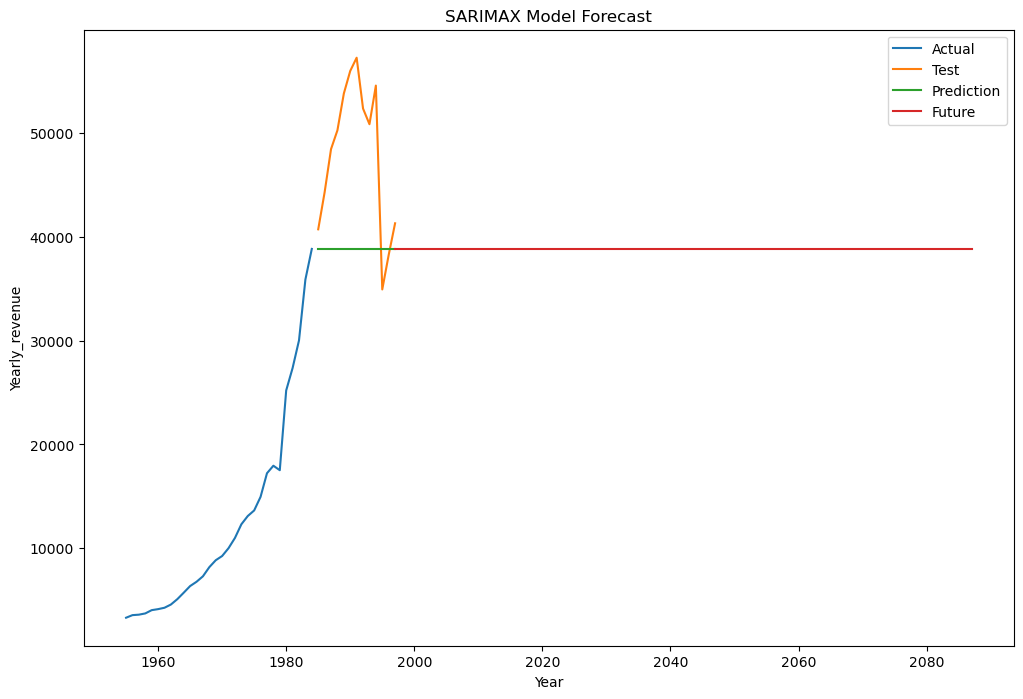

In [54]:
plt.figure(figsize=(12, 8))

plt.plot(train_df['Yearly_revenue'], label='Actual')
plt.plot(test_df['Yearly_revenue'], label='Test')
plt.plot(test_predictions2, label='Prediction')
plt.plot(forecast_further2, label='Future')

plt.title('SARIMAX Model Forecast')
plt.xlabel('Year')
plt.ylabel('Yearly_revenue')
plt.legend()

plt.show()

In [55]:
mape_test_arima2 = mean_absolute_percentage_error(test_df['Yearly_revenue'],test_predictions2)
print('MAPE for TEST Data:', mape_test_arima2)

MAPE for TEST Data: 0.19009645478424367


In [56]:
import statsmodels.api as sm
model_1 = sm.tsa.statespace.SARIMAX(train_df['Yearly_revenue'], order=(1,3,1), seasonal_order = (0,0,0,0))
model_1_fit = model_1.fit()

print(model_1_fit.summary())

                               SARIMAX Results                                
Dep. Variable:         Yearly_revenue   No. Observations:                   30
Model:               SARIMAX(1, 3, 1)   Log Likelihood                -241.519
Date:                Thu, 23 Jan 2025   AIC                            489.039
Time:                        11:43:33   BIC                            492.926
Sample:                    01-01-1955   HQIC                           490.195
                         - 01-01-1984                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5640      0.159     -3.553      0.000      -0.875      -0.253
ma.L1         -0.9998      0.124     -8.056      0.000      -1.243      -0.757
sigma2      3.181e+06   3.91e-08   8.14e+13      0.0

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


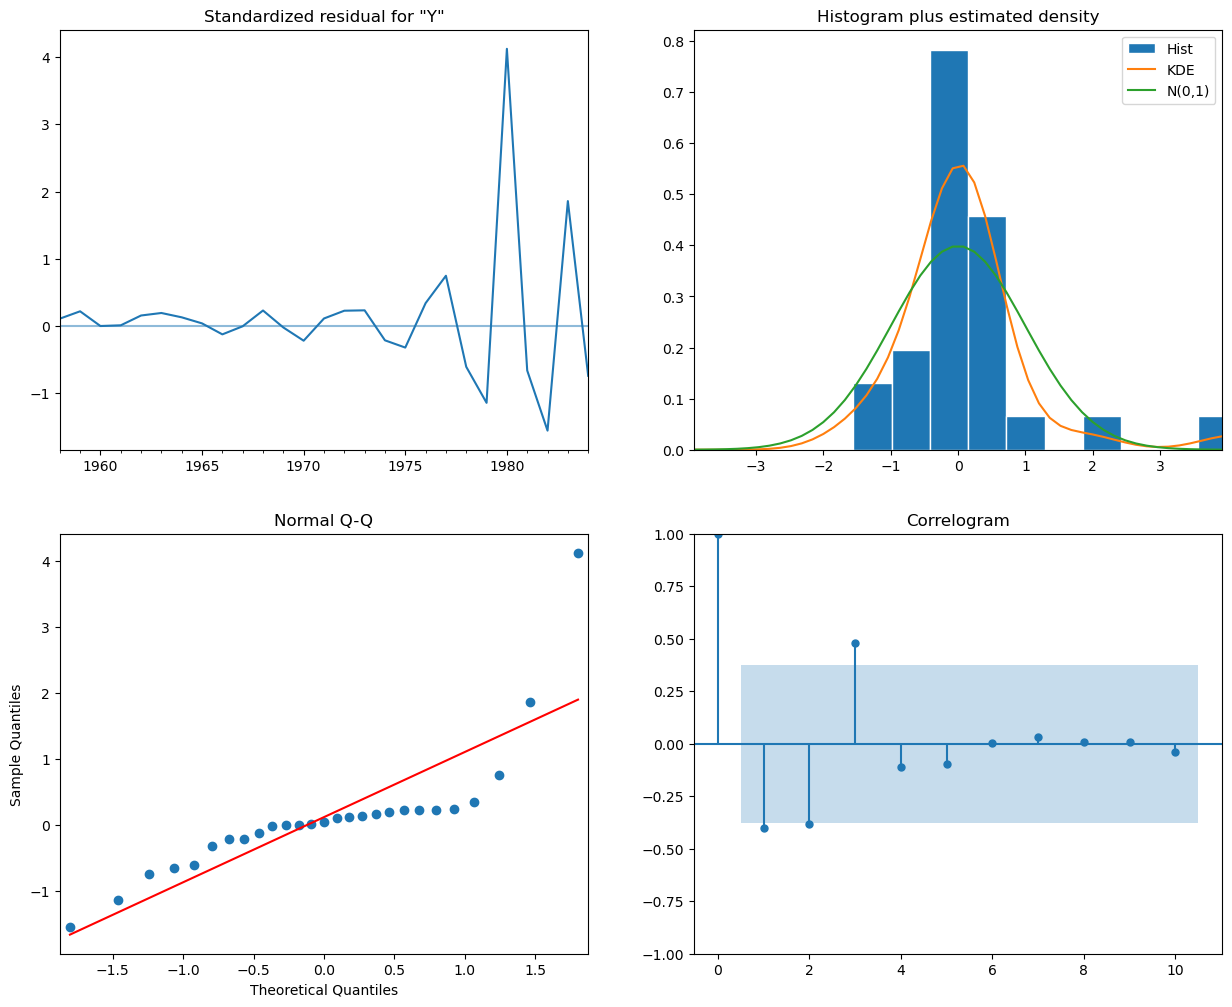

In [57]:
model_1_fit.plot_diagnostics(figsize=(15,12))
plt.show()

In [62]:
test_predictions1 = model_1_fit.forecast(len(test_df))
forecast_further1 = model_1_fit.forecast(len(test_df['Yearly_revenue'])+10)
forecast_further1 = forecast_further1[test_df.index.max():]
forecast_further1

1997-01-01    102311.686636
1998-01-01    107978.137576
1999-01-01    113761.412129
2000-01-01    119660.628747
2001-01-01    125676.284606
2002-01-01    131808.099308
2003-01-01    138056.230992
2004-01-01    144420.590471
2005-01-01    150901.228045
2006-01-01    157498.115346
2007-01-01    164211.268373
Freq: AS-JAN, Name: predicted_mean, dtype: float64

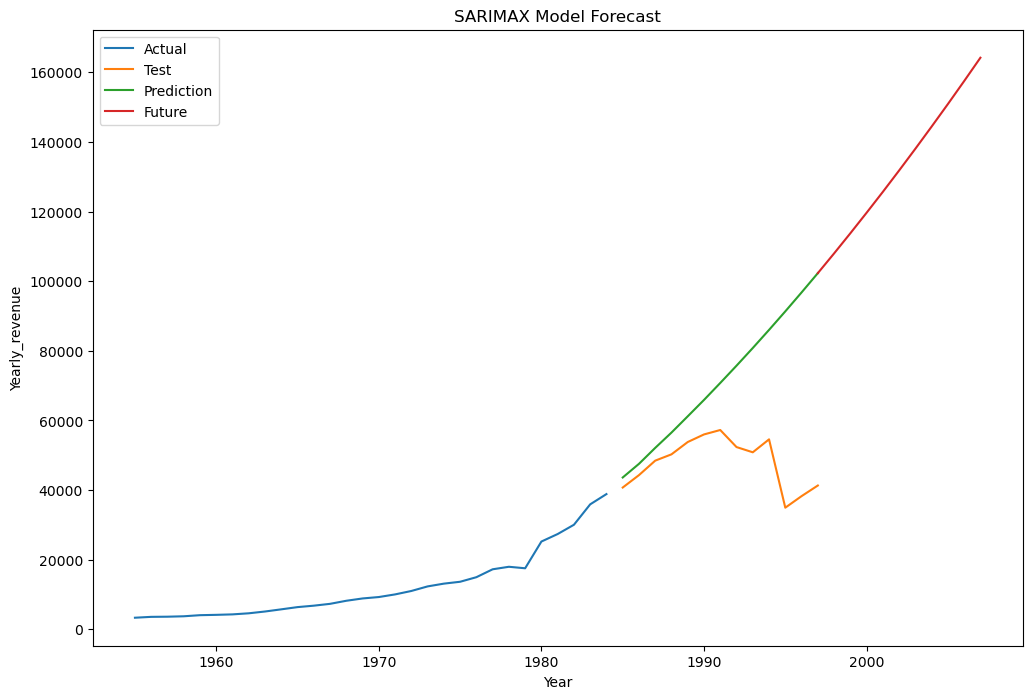

In [63]:
plt.figure(figsize=(12, 8))

plt.plot(train_df['Yearly_revenue'], label='Actual')
plt.plot(test_df['Yearly_revenue'], label='Test')
plt.plot(test_predictions1, label='Prediction')
plt.plot(forecast_further1, label='Future')

plt.title('SARIMAX Model Forecast')
plt.xlabel('Year')
plt.ylabel('Yearly_revenue')
plt.legend()

plt.show()

In [61]:
mape_test_arima1 = mean_absolute_percentage_error(test_df['Yearly_revenue'],test_predictions1)
print('MAPE for TEST Data:', mape_test_arima1)

MAPE for TEST Data: 0.54849386356058
